In [1]:
from __future__ import print_function
import sys,os,datetime
import cv2 as cv
import cv2 as cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
import csv

In [2]:
print('openCV',cv.__version__)
print('numpy',np.__version__)

openCV 3.2.0
numpy 1.13.3


In [3]:
dirTrain1 = '../Data/train/train/level-1'
dirTrain2 = '../Data/train/train/level-2'
dirTrain3 = '../Data/train/train/level-3'
dirTrain  = dirTrain2
dirDev    = '../Data/dev/dev'

In [4]:
def NNTrain(dirTrain) :
    listTrain= os.listdir(dirTrain); len(listTrain); listTrain[:12]
    listTrainNN = []
    for ff in listTrain :
        if ff.lower().endswith('.txt') : listTrainNN.append(ff.split('_')[0])
    return(listTrainNN)
listTrainNN = NNTrain(dirTrain)
len(listTrainNN), listTrainNN[:15]

(1495,
 ['1003',
  '1009',
  '100',
  '1012',
  '1018',
  '1021',
  '984',
  '994',
  '995',
  '997',
  '9',
  '952',
  '955',
  '956',
  '959'])

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-1
751 302 213.09587217 36.0 489.453206012 0.140102480059 1.72123602893


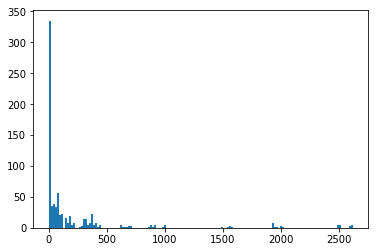

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-2
1495 540 258.478929766 47.0 544.611454936 0.169940124764 1.72846811308


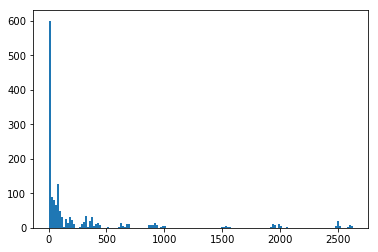

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-3
1873 540 258.515750133 60.0 542.370915742 0.169964332764 1.7258382643


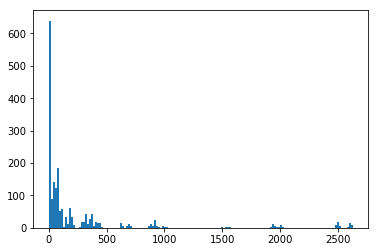

In [6]:
# Build statistics on masks
for dirTrain in (dirTrain1,dirTrain2,dirTrain3) :
    listTrainNN = NNTrain(dirTrain)
    maskSize = []
    for NN in range(len(listTrainNN)) :
        #print(NN)
        img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
        img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
        img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1)
        maskSize.append(img3[img3>0.5].size)
        #img1      = cv.GaussianBlur(img1,(3,3),0)
        #img2      = cv.GaussianBlur(img2,(3,3),0)
    print(img1.shape,img2.shape,img3.shape, dirTrain)
    
    maskSize = np.array(maskSize)
    print(len(maskSize), len(maskSize[maskSize==0]), maskSize.mean(), np.median(maskSize), maskSize.std(), maskSize.mean()/(390*390)*100.0, float(maskSize.max())/(390*390)*100.0)
    plt.hist(maskSize,bins=150); plt.show()

In [7]:
def diffPicts (img1, img2) :
    diff = []
    for cc in range(img1.shape[2]) :
        ccc   = np.abs(img1[:,:,cc]-img2[:,:,cc])
        cccL2 = np.sqrt(np.square(ccc).mean())
        cccL1 = ccc.max()
        diff.append([cccL1,cccL2,ccc])
    diffL2 = np.zeros(ccc.shape)
    for L1,L2,ccc in diff : diffL2 += np.square(ccc)
    diffL2 = np.sqrt(diffL2)
    return(diff,diffL2)

def minDeltaRC (img1,img2, ranging=range(-5,6), printOK=False) :
    r0,c0 = (img2.shape[0]-img1.shape[0])/2, (img2.shape[1]-img1.shape[1])/2
    minL2 = [390*390*250.0,0,0]
    for dr in ranging :
        for dc in ranging :
            imgX2 = img2[r0+dr:r0+img1.shape[0]+dr,c0+dc:c0+img1.shape[1]+dc,:]
            diff, L2 = diffPicts(img1,imgX2)
            if (minL2[0]>L2.mean()) : minL2 = (L2.mean(),dr,dc,r0+dr,c0+dc)
            if printOK : print (dr,dc,'\t',minL2[0],'\t',L2.max(),L2.mean(),L2.std(),np.median(L2))
    return(minL2)

print('min=',minDeltaRC(img1,img2))

min= (8.7705751775521197, 0, 1, 55, 56)


In [8]:
def pictNorm (img255, std=False) :
    imgF32 = np.float32(img255) 
    for cc in range(img255.shape[2]) :
        imgF32[:,:,cc] -= imgF32[:,:,cc].mean()
        if std : imgF32[:,:,cc] /= imgF32[:,:,cc].std()**2
        imgF32[:,:,cc] /= 127.0
    return(imgF32)

In [9]:
def computeORB (img, debug=False) :
    orb    = cv2.ORB_create();
    kp     = orb.detect(img,None)
    kp,des = orb.compute(img,kp)
    if debug :
        print (len(kp))
        print (len(des),len(des[0]),"\n",des[0],"\n",des[1])
    return kp,des

def computeMatches (des1,des2) :
    if True :
        bf      = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
        matches = bf.match(des1,des2);
        #????matches = bf.knnMatch(des1,des2,k=1);
    if False :
        index_params = dict(algorithm = 6, #cv2.FLANN_INDEX_LSH,
                            table_number = 6, 
                            key_size = 12,    
                            multi_probe_level = 1)
        search_params = dict(checks=100)
        flann   = cv2.FlannBasedMatcher(index_params,search_params)
        matchesI = flann.knnMatch(des1,des2,k=3);
        matches  = [];
        for mI in matchesI :
            for m in mI : matches.append(m);
    return matches    

def drawMatches(img1,kp1,des1,img2,kp2,des2, show=False, showNN=20):
    matches = computeMatches(des1,des2);
    matches = sorted(matches,key=lambda x:x.distance)
    if  show :
        imgM    = img1.copy()
        #imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],imgM,flags=4)
        imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:showNN],imgM,flags=2) #4)
        #imgM    = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,imgM,flags=2) #4)
        
        plt.figure(figsize=(15,15)); plt.imshow(imgM), plt.show()
    return(matches)


In [10]:
len(listTrainNN)

1873

In [137]:
shape2D = (416,416)
X1 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
X2 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
YY = np.zeros((len(listTrainNN),)+shape2D+(1,),dtype=np.float32)
X1.shape, X2.shape,YY.shape

((1873, 416, 416, 3), (1873, 416, 416, 3), (1873, 416, 416, 1))

In [138]:
416-390

26

In [80]:
print(datetime.datetime.now())

shape2D = (416,416)

for ii,dirTrain in enumerate((dirTrain1,dirTrain2,dirTrain3)) :
    
    #if ii==1 : break
    
    listTrainNN = NNTrain(dirTrain)

    X1 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
    X2 = np.zeros((len(listTrainNN),)+shape2D+(3,),dtype=np.float32)
    YY = np.zeros((len(listTrainNN),)+shape2D+(1,),dtype=np.float32)
    print(datetime.datetime.now(),X1.shape, X2.shape,YY.shape,dirTrain)
    
    for NN in range(len(listTrainNN)) :
        img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
        img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
        img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1); img3 = img3.reshape(img3.shape+(1,))



        if 1 :
            img1 = cv2.GaussianBlur(img1,(3,3),0)
            img2 = cv2.GaussianBlur(img2,(3,3),0)

        if 0 :
            img1 = cv2.boxFilter(img1,-1,(5,5))
            img2 = cv2.boxFilter(img2,-1,(5,5))


        if 1 :
            img1  = pictNorm(img1)
            img2  = pictNorm(img2)

        rcL2,_,_,r0,c0 = minDeltaRC(img1,img2,ranging=range(-10,10))
        img2X = img2[r0:r0+img1.shape[0],c0:c0+img1.shape[1]]

        if NN%100==0 : print(datetime.datetime.now(),NN,rcL2,r0,c0)

        if 0 :
            img1 = cv2.GaussianBlur(img1,(3,3),0)
            img2X = cv2.GaussianBlur(img2X,(3,3),0)

        if 1 :
            img1  = cv2.boxFilter(img1, -1,(5,5))
            img2X = cv2.boxFilter(img2X,-1,(5,5))

        X1[NN,13:13+390,13:13+390,:], X2[NN,13:13+390,13:13+390,:], YY[NN,13:13+390,13:13+390,:] = img1, img2X, img3


    if 1 :
        np.save(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'),X1)
        np.save(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'),X2)
        np.save(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'),YY)
        print(datetime.datetime.now(),'Save:',X1.shape, X2.shape,YY.shape,dirTrain)
        
    del X1,X2,YY
        
print(datetime.datetime.now())

2018-02-12 08:26:44.394974
2018-02-12 08:26:44.399563 (751, 416, 416, 3) (751, 416, 416, 3) (751, 416, 416, 1) ../Data/train/train/level-1
2018-02-12 08:26:45.352151 0 0.0658074848063 55 56
2018-02-12 08:28:17.167419 100 0.0567938326306 56 56
2018-02-12 08:29:41.904455 200 0.0676420703097 56 53
2018-02-12 08:31:06.054255 300 0.0566413581779 54 50
2018-02-12 08:32:30.244880 400 0.0549176484386 46 64
2018-02-12 08:33:54.280129 500 0.0510736484509 54 56
2018-02-12 08:35:18.188724 600 0.0628774579128 55 55
2018-02-12 08:36:42.517704 700 0.205298348405 55 52
2018-02-12 08:37:41.104001 Save: (751, 416, 416, 3) (751, 416, 416, 3) (751, 416, 416, 1) ../Data/train/train/level-1
2018-02-12 08:37:41.244491 (1495, 416, 416, 3) (1495, 416, 416, 3) (1495, 416, 416, 1) ../Data/train/train/level-2
2018-02-12 08:37:42.200435 0 0.135193295812 55 55
2018-02-12 08:39:49.218562 100 0.110332033177 55 55
2018-02-12 08:41:22.393742 200 0.0446885574285 55 55
2018-02-12 08:42:52.506891 300 0.061369903808 55 54


In [11]:
dirForSave = '../Work'

In [154]:
if 0 :
    np.save(os.path.join(dirForSave,'X1.npy'),X1)
    np.save(os.path.join(dirForSave,'X2.npy'),X2)
    np.save(os.path.join(dirForSave,'YY.npy'),YY)
    
if 0 :
    ii = 0
    X1 = np.load(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'))
    X2 = np.load(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'))
    YY = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
    print(datetime.datetime.now(),'Load: ',ii,X1.shape, X2.shape,YY.shape)
    
if 0 :
    iil = []
    for ii in (0,1,2) :
        YY = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
        iil.append(len(YY))
    iis = int(np.array(iil).sum())
    
    X1 = np.zeros((iis,)+shape2D+(3,),dtype=np.float32)
    X2 = np.zeros((iis,)+shape2D+(3,),dtype=np.float32)
    YY = np.zeros((iis,)+shape2D+(1,),dtype=np.float32)
    
    iis = 0
    
    for ii in (0,1,2) :
        
        T1  = np.load(os.path.join(dirForSave,'X1-'+str(ii)+'.npy'))
        T2  = np.load(os.path.join(dirForSave,'X2-'+str(ii)+'.npy'))
        TT  = np.load(os.path.join(dirForSave,'YY-'+str(ii)+'.npy'))
        
        X1[iis:iis+len(TT)], X2[iis:iis+len(TT)], YY[iis:iis+len(TT)] = T1, T2, TT
        
        iis+= len(TT)
        
        del TT,T1, T2
        
    print(datetime.datetime.now(),'Load: ', X1.shape, X2.shape, YY.shape)
    

2018-02-12 21:06:48.973825 Load:  (4119, 416, 416, 3) (4119, 416, 416, 3) (4119, 416, 416, 1)


In [155]:
X1.shape,X2.shape,YY.shape

((4119, 416, 416, 3), (4119, 416, 416, 3), (4119, 416, 416, 1))